In [218]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import pickle
from sklearn.metrics import accuracy_score


In [219]:

#======================================================================
# Load the dataset
fields = ['value', 'perf']
data_attack = pd.read_csv('../data/data.csv', skipinitialspace=True, usecols=fields, sep = ", ", engine='python')
data_normal = pd.read_csv('../data/data_normal.csv', skipinitialspace=True, usecols=fields, sep = ", ", engine='python')
print(data_attack.head())


           value                           perf
0.010162    2599  armv8_cortex_a72/br_mis_pred/
0.010162  118890      armv8_cortex_a72/br_pred/
0.010162    1818                   cache-misses
0.010162  220065               cache-references
0.010162  200215                      ldst_spec


In [220]:
fields = ['value', 'perf']
normal_2 = pd.read_csv('../data/normal_2.csv', skipinitialspace=True, usecols=fields, sep = ", ", engine='python')
attack_2 = pd.read_csv('../data/attack_2.csv', skipinitialspace=True, usecols=fields, sep = ", ", engine='python')
frames = [normal_2, attack_2, data_normal]
print(data_attack.shape,normal_2.shape, attack_2.shape,data_normal.shape)
#print(data_attack.shape[0])


(7182, 2) (6075, 2) (3440, 2) (3440, 2)


In [221]:
pd.set_option('display.max_colwidth', None)
c = 'perf'
data_new = data_attack.set_index([data_attack.groupby(c).cumcount() + 1, c]).unstack().sort_index(1, 1)
data_new.columns = data_new.columns.droplevel(0)
data_new['y'] = np.ones([data_new.shape[0],1])
i = 0
for frame in frames:
    temp = frame.set_index([frame.groupby(c).cumcount() + 1, c]).unstack().sort_index(1, 1)
    #data_normal_new = data_normal.set_index([data_normal.groupby(c).cumcount() + 1, c]).unstack().sort_index(1, 1)
    temp.columns = temp.columns.droplevel(0)
    if i%2 == 0: #TODO fix this logic
        temp['y'] = np.zeros([temp.shape[0],1])
    else:
        temp['y'] = np.ones([temp.shape[0],1])
    i=i+1
    data_new = pd.concat([data_new,temp],axis=0)

    #data_new.tail()
#data_new.columns = data_new.columns.droplevel(0)
print(data_new)

perf  armv8_cortex_a72/br_mis_pred/  armv8_cortex_a72/br_pred/  cache-misses  \
1                            2599.0                   118890.0        1818.0   
2                            4122.0                   232571.0        3051.0   
3                             694.0                  1128257.0         436.0   
4                             479.0                  1878142.0         369.0   
5                             284.0                  2339224.0         263.0   
..                              ...                        ...           ...   
684                         69241.0                  2996293.0         148.0   
685                         67069.0                  2907718.0         187.0   
686                         71851.0                  3072065.0         181.0   
687                         71184.0                  2974060.0         149.0   
688                         14436.0                   601533.0        1023.0   

perf  cache-references   ldst_spec    y

C:\Users\Sirius\AppData\Local\Temp/ipykernel_23868/2837050059.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only
  data_new = data_attack.set_index([data_attack.groupby(c).cumcount() + 1, c]).unstack().sort_index(1, 1)
C:\Users\Sirius\AppData\Local\Temp/ipykernel_23868/2837050059.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only
  temp = frame.set_index([frame.groupby(c).cumcount() + 1, c]).unstack().sort_index(1, 1)


In [222]:
# Remove outliers
for df in data_new.drop(['y'],axis=1):
    q_low = data_new[df].quantile(0.01)
    q_hi  = data_new[df].quantile(0.99)
    data_new = data_new[(data_new[df]< q_hi) & (data_new[df] > q_low)]

#TODO fix this unused
for df in data_normal_new:
    q_low = data_normal_new[df].quantile(0.01)
    q_hi  = data_normal_new[df].quantile(0.99)
    data_normal_new = data_normal_new[(data_normal_new[df]< q_hi) & (data_normal_new[df] > q_low)]

Removed the outliars from the data
Calculate br_miss_rate, cache_miss_rate, relative_spec_load

In [223]:
# create 3 new features branch miss rate, cache miss rate, spec load
data_new['br_miss_rate']=data_new['armv8_cortex_a72/br_mis_pred/'].truediv(data_new['armv8_cortex_a72/br_pred/'])
data_new['cache_miss_rate']=data_new['cache-misses'].mul(100).truediv(data_new['cache-references'])
data_new['spec_load'] = data_new['ldst_spec'].truediv(data_new['ldst_spec'].max())

data_normal_new['br_miss_rate']=data_normal_new['armv8_cortex_a72/br_mis_pred/'].truediv(data_normal_new['armv8_cortex_a72/br_pred/'])
data_normal_new[('cache_miss_rate')]=data_normal_new[('cache-misses')].mul(100).truediv(data_normal_new[('cache-references')])
data_normal_new[('spec_load')] = data_normal_new[('ldst_spec')].truediv(data_normal_new[('ldst_spec')].max())

scaler = MinMaxScaler()
#data_new['br_miss_rate'] = scaler.fit_transform(data_new['br_miss_rate'].values.reshape(-1,1))
#data_new['cache_miss_rate'] = scaler.fit_transform(data_new['cache_miss_rate'].values.reshape(-1,1))
#data_new['ldst_spec'] = scaler.fit_transform(data_new['ldst_spec'].values.reshape(-1,1))

#data_normal_new['br_miss_rate'] = scaler.fit_transform(data_normal_new['br_miss_rate'].values.reshape(-1,1))
#data_normal_new['cache_miss_rate'] = scaler.fit_transform(data_normal_new['cache_miss_rate'].values.reshape(-1,1))
#data_normal_new['ldst_spec'] = scaler.fit_transform(data_normal_new['ldst_spec'].values.reshape(-1,1))

print(data_new.head)

<bound method NDFrame.head of perf  armv8_cortex_a72/br_mis_pred/  armv8_cortex_a72/br_pred/  cache-misses  \
14                          60819.0                  2629485.0        3672.0   
19                          61861.0                  2632992.0        3438.0   
23                          60652.0                  2625844.0        3973.0   
24                          59746.0                  2630356.0        3528.0   
29                          59799.0                  2640267.0        3434.0   
..                              ...                        ...           ...   
680                         71191.0                  3018915.0         184.0   
681                         72125.0                  3016525.0         188.0   
682                         71359.0                  3024751.0         152.0   
683                         68837.0                  2951922.0         181.0   
685                         67069.0                  2907718.0         187.0   

perf  cac

<AxesSubplot:ylabel='Frequency'>

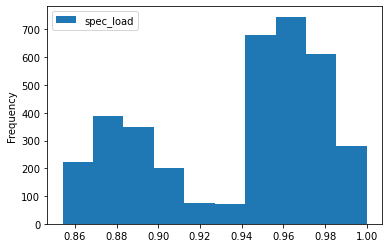

In [224]:
#data_new[('cache_miss_rate')].plot.hist(label='cache_miss_rate',legend=True)
#data_new[('br_miss_rate')].plot.hist(label='br_miss_rate',legend=True)
data_new[('spec_load')].plot.hist(label='spec_load',legend=True)

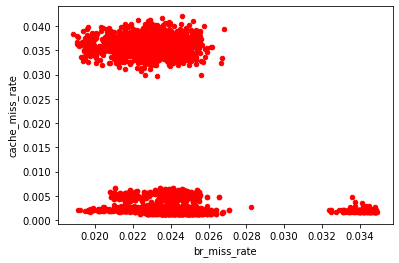

In [225]:


ax =data_normal_new.plot.scatter(x='br_miss_rate', color="g",y='cache_miss_rate',legend=True)
X= data_new.plot.scatter(x='br_miss_rate',y='cache_miss_rate', color="r",legend=True,ax=ax)


<AxesSubplot:>

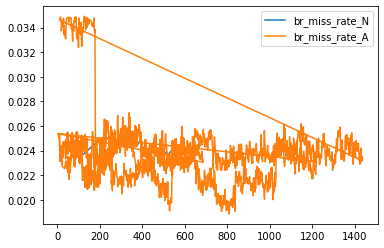

In [226]:
#data_normal_new[('cache_miss_rate')].plot(label='cache_miss_rate',legend=True)
data_normal_new[('br_miss_rate')].plot(label='br_miss_rate_N',legend=True)
#data_normal_new[('spec_load')].plot(label='spec_load',legend=True)
#data_new[('cache_miss_rate')].plot(label='cache_miss_rate',legend=True)
data_new[('br_miss_rate')].plot(label='br_miss_rate_A',legend=True)
#data_new[('spec_load')].plot(label='spec_load',legend=True)

In [227]:

data_train = data_new[['cache_miss_rate','br_miss_rate','spec_load']]
y_train = data_new['y']
numeric_pipeline = Pipeline(steps=[("impute", SimpleImputer(strategy="mean")), ("scale", StandardScaler())])
num_cols = data_train.columns
full_processor = ColumnTransformer(transformers=[("numeric", numeric_pipeline, num_cols)])

# Apply preprocessing
X_processed = full_processor.fit_transform(data_train)
#y_processed = SimpleImputer(strategy="most_frequent").fit_transform(y.values.reshape(-1, 1))


X_train, X_test, y_train, y_test = train_test_split(data_train, y_train, stratify=y_train, random_state=1221219)
#xgb_cl = xgb.XGBClassifier()

param_grid = {
    "max_depth": [3, 4, 5, 7],
    "learning_rate": [0.1, 0.01, 0.05, 0.5],
    "gamma": [0, 0.25, 1],
    "reg_lambda": [0, 1, 10],
    "scale_pos_weight": [1, 3, 5],
    "subsample": [0.8],
    "colsample_bytree": [0.5],
}

# Init classifier
xgb_cl = xgb.XGBClassifier(objective="binary:logistic")

# Init Grid Search
grid_cv = GridSearchCV(xgb_cl, param_grid, n_jobs=-1, cv=3, scoring="roc_auc")

# Fit
grid_cv.fit(X_train, y_train)

filename = 'finalized_model.sav'
pickle.dump(grid_cv, open(filename, 'wb'))

[19:16:02] WARNING: D:\bld\xgboost-split_1643227225381\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Installed_soft\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [228]:

# Predict
loaded_model = pickle.load(open(filename, 'rb'))
preds = loaded_model.predict(X_test)
accuracy_score(y_test, preds)


0.8169790518191842